# Лабораторная работа 2: «Разработка сверточной нейронной сети с использованием PyTorch»

## Цели и задачи

**Цель работы** — разработать и обучить сверточную нейронную сеть для задачи классификации изображений на наборе данных CIFAR-10 с использованием фреймворка PyTorch.

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time

# Проверка доступности GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


## 1. Загрузка и предобработка данных CIFAR-10

In [55]:
# Вычислим mean и std по RGB каналам для нормализации
temp_transform = transforms.Compose([
    transforms.ToTensor()
])

# Загружаем тренировочные данные для вычисления статистик
temp_trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=temp_transform)
temp_trainloader = torch.utils.data.DataLoader(
    temp_trainset, batch_size=len(temp_trainset), shuffle=False)


data = next(iter(temp_trainloader))[0] # Берем только изображения
mean = data.mean(dim=(0, 2, 3))        # Среднее по каналам (batch, height, width)
std = data.std(dim=(0, 2, 3))          # STD по каналам (batch, height, width)
print(f"Mean: {mean.tolist()}")
print(f"Std:  {std.tolist()}")


# Используем вычисленные значения для трансформации
norm_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist()),
])

Mean: [0.491400808095932, 0.48215898871421814, 0.44653093814849854]
Std:  [0.24703224003314972, 0.24348513782024384, 0.26158785820007324]


In [56]:
# Загрузка тренировочного и тестового наборов данных
batch_size = 128

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=norm_transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=norm_transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Классы CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

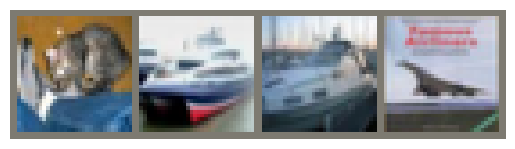

cat             ship            ship            plane          


In [57]:
def imshow_normalized(img, mean, std):
    # Денормализуем для отображения
    img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
    img = torch.clamp(img, 0, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

dataiter = iter(testloader)
images, labels = next(dataiter)

imshow_normalized(torchvision.utils.make_grid(images[:4]), mean.tolist(), std.tolist())
print(' '.join(f'{classes[labels[j]]:15s}' for j in range(4)))

## 2. Реализация ResNet18

In [58]:
class BasicBlock(nn.Module):
    expansion = 1 # коэффициент расширения каналов (для ResNet50+)

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [59]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

model = ResNet18().to(device)
# print(model)

## 3. Функция потерь и оптимизатор

In [60]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [61]:
def calculate_test_loss_and_accuracy(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Усредняем loss по всем батчам
    avg_test_loss = test_loss / len(testloader)
    test_accuracy = 100 * correct / total

    return avg_test_loss, test_accuracy

## 4. Обучение модели

In [62]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

num_epochs = 50
best_accuracy = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Прогресс-бар
    loop = tqdm(trainloader, desc=f'Epoch [{epoch+1}/{num_epochs}]')

    for i, data in enumerate(loop):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Обнуление градиентов
        optimizer.zero_grad()

        # Прямой проход + обратный проход + оптимизация
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Статистика
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Обновление прогресс-бара
        loop.set_postfix(loss=loss.item())

    # Вычисление точности
    train_accuracy = 100 * correct / total
    # Вычисление test loss и accuracy
    test_loss, test_accuracy = calculate_test_loss_and_accuracy(model, testloader, criterion)

    train_losses.append(running_loss / len(trainloader))
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    # Обновление learning rate
    scheduler.step()


    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {running_loss/len(trainloader):.4f}, '
          f'Test Loss: {test_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, '
          f'Test Accuracy: {test_accuracy:.2f}%')

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), 'best_resnet18_cifar10.pth')

print(f'Best test accuracy: {best_accuracy:.2f}%')

Epoch [1/50]: 100%|██████████| 391/391 [00:39<00:00,  9.98it/s, loss=1.52]


Epoch [1/50], Train Loss: 1.9019, Test Loss: 1.4899, Train Accuracy: 35.41%, Test Accuracy: 45.50%


Epoch [2/50]: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s, loss=1.47]


Epoch [2/50], Train Loss: 1.2639, Test Loss: 1.2016, Train Accuracy: 54.32%, Test Accuracy: 57.17%


Epoch [3/50]: 100%|██████████| 391/391 [00:40<00:00,  9.59it/s, loss=0.789]


Epoch [3/50], Train Loss: 1.0050, Test Loss: 1.0244, Train Accuracy: 63.94%, Test Accuracy: 64.57%


Epoch [4/50]: 100%|██████████| 391/391 [00:40<00:00,  9.63it/s, loss=0.867]


Epoch [4/50], Train Loss: 0.8298, Test Loss: 0.8917, Train Accuracy: 70.51%, Test Accuracy: 68.29%


Epoch [5/50]: 100%|██████████| 391/391 [00:40<00:00,  9.61it/s, loss=0.587]


Epoch [5/50], Train Loss: 0.6959, Test Loss: 0.9002, Train Accuracy: 75.44%, Test Accuracy: 68.90%


Epoch [6/50]: 100%|██████████| 391/391 [00:40<00:00,  9.59it/s, loss=0.446]


Epoch [6/50], Train Loss: 0.5825, Test Loss: 0.7330, Train Accuracy: 79.62%, Test Accuracy: 75.12%


Epoch [7/50]: 100%|██████████| 391/391 [00:40<00:00,  9.63it/s, loss=0.542]


Epoch [7/50], Train Loss: 0.4931, Test Loss: 0.7187, Train Accuracy: 82.87%, Test Accuracy: 76.12%


Epoch [8/50]: 100%|██████████| 391/391 [00:40<00:00,  9.60it/s, loss=0.45]


Epoch [8/50], Train Loss: 0.4296, Test Loss: 0.6071, Train Accuracy: 84.88%, Test Accuracy: 79.55%


Epoch [9/50]: 100%|██████████| 391/391 [00:40<00:00,  9.62it/s, loss=0.423]


Epoch [9/50], Train Loss: 0.3888, Test Loss: 0.5871, Train Accuracy: 86.63%, Test Accuracy: 80.10%


Epoch [10/50]: 100%|██████████| 391/391 [00:40<00:00,  9.60it/s, loss=0.523]


Epoch [10/50], Train Loss: 0.3454, Test Loss: 0.6773, Train Accuracy: 87.95%, Test Accuracy: 77.70%


Epoch [11/50]: 100%|██████████| 391/391 [00:40<00:00,  9.62it/s, loss=0.399]


Epoch [11/50], Train Loss: 0.3213, Test Loss: 0.6332, Train Accuracy: 88.74%, Test Accuracy: 79.74%


Epoch [12/50]: 100%|██████████| 391/391 [00:40<00:00,  9.60it/s, loss=0.252]


Epoch [12/50], Train Loss: 0.2893, Test Loss: 0.6313, Train Accuracy: 89.76%, Test Accuracy: 80.01%


Epoch [13/50]: 100%|██████████| 391/391 [00:40<00:00,  9.62it/s, loss=0.29]


Epoch [13/50], Train Loss: 0.2689, Test Loss: 0.7933, Train Accuracy: 90.60%, Test Accuracy: 75.67%


Epoch [14/50]: 100%|██████████| 391/391 [00:40<00:00,  9.56it/s, loss=0.546]


Epoch [14/50], Train Loss: 0.2467, Test Loss: 0.7182, Train Accuracy: 91.53%, Test Accuracy: 77.53%


Epoch [15/50]: 100%|██████████| 391/391 [00:40<00:00,  9.61it/s, loss=0.28]


Epoch [15/50], Train Loss: 0.2412, Test Loss: 0.7834, Train Accuracy: 91.59%, Test Accuracy: 76.33%


Epoch [16/50]: 100%|██████████| 391/391 [00:40<00:00,  9.60it/s, loss=0.15]


Epoch [16/50], Train Loss: 0.2238, Test Loss: 0.7162, Train Accuracy: 92.28%, Test Accuracy: 77.98%


Epoch [17/50]: 100%|██████████| 391/391 [00:40<00:00,  9.63it/s, loss=0.244]


Epoch [17/50], Train Loss: 0.2194, Test Loss: 0.6359, Train Accuracy: 92.46%, Test Accuracy: 80.70%


Epoch [18/50]: 100%|██████████| 391/391 [00:40<00:00,  9.62it/s, loss=0.166]


Epoch [18/50], Train Loss: 0.2115, Test Loss: 0.6046, Train Accuracy: 92.67%, Test Accuracy: 81.51%


Epoch [19/50]: 100%|██████████| 391/391 [00:40<00:00,  9.64it/s, loss=0.198]


Epoch [19/50], Train Loss: 0.2036, Test Loss: 0.5691, Train Accuracy: 92.98%, Test Accuracy: 81.81%


Epoch [20/50]: 100%|██████████| 391/391 [00:40<00:00,  9.60it/s, loss=0.283]


Epoch [20/50], Train Loss: 0.2059, Test Loss: 0.8139, Train Accuracy: 92.78%, Test Accuracy: 76.14%


Epoch [21/50]: 100%|██████████| 391/391 [00:40<00:00,  9.63it/s, loss=0.269]


Epoch [21/50], Train Loss: 0.1982, Test Loss: 0.6617, Train Accuracy: 93.17%, Test Accuracy: 80.37%


Epoch [22/50]: 100%|██████████| 391/391 [00:40<00:00,  9.62it/s, loss=0.411]


Epoch [22/50], Train Loss: 0.1903, Test Loss: 0.6471, Train Accuracy: 93.53%, Test Accuracy: 80.05%


Epoch [23/50]: 100%|██████████| 391/391 [00:40<00:00,  9.62it/s, loss=0.212]


Epoch [23/50], Train Loss: 0.1881, Test Loss: 0.7446, Train Accuracy: 93.51%, Test Accuracy: 78.14%


Epoch [24/50]: 100%|██████████| 391/391 [00:40<00:00,  9.63it/s, loss=0.208]


Epoch [24/50], Train Loss: 0.1913, Test Loss: 0.6361, Train Accuracy: 93.46%, Test Accuracy: 81.15%


Epoch [25/50]: 100%|██████████| 391/391 [00:40<00:00,  9.62it/s, loss=0.183]


Epoch [25/50], Train Loss: 0.1895, Test Loss: 0.7897, Train Accuracy: 93.50%, Test Accuracy: 77.14%


Epoch [26/50]: 100%|██████████| 391/391 [00:40<00:00,  9.65it/s, loss=0.284]


Epoch [26/50], Train Loss: 0.1905, Test Loss: 0.7908, Train Accuracy: 93.39%, Test Accuracy: 77.75%


Epoch [27/50]: 100%|██████████| 391/391 [00:40<00:00,  9.62it/s, loss=0.348]


Epoch [27/50], Train Loss: 0.1876, Test Loss: 0.5735, Train Accuracy: 93.58%, Test Accuracy: 82.42%


Epoch [28/50]: 100%|██████████| 391/391 [00:40<00:00,  9.63it/s, loss=0.207]


Epoch [28/50], Train Loss: 0.1776, Test Loss: 0.7729, Train Accuracy: 93.94%, Test Accuracy: 77.25%


Epoch [29/50]: 100%|██████████| 391/391 [00:40<00:00,  9.61it/s, loss=0.225]


Epoch [29/50], Train Loss: 0.1722, Test Loss: 0.6307, Train Accuracy: 94.09%, Test Accuracy: 80.15%


Epoch [30/50]: 100%|██████████| 391/391 [00:40<00:00,  9.64it/s, loss=0.524]


Epoch [30/50], Train Loss: 0.1805, Test Loss: 0.8294, Train Accuracy: 93.82%, Test Accuracy: 76.85%


Epoch [31/50]: 100%|██████████| 391/391 [00:40<00:00,  9.62it/s, loss=0.022]


Epoch [31/50], Train Loss: 0.0502, Test Loss: 0.4018, Train Accuracy: 98.61%, Test Accuracy: 87.66%


Epoch [32/50]: 100%|██████████| 391/391 [00:40<00:00,  9.64it/s, loss=0.0115]


Epoch [32/50], Train Loss: 0.0121, Test Loss: 0.4067, Train Accuracy: 99.91%, Test Accuracy: 87.85%


Epoch [33/50]: 100%|██████████| 391/391 [00:40<00:00,  9.59it/s, loss=0.00497]


Epoch [33/50], Train Loss: 0.0072, Test Loss: 0.4101, Train Accuracy: 99.99%, Test Accuracy: 87.91%


Epoch [34/50]: 100%|██████████| 391/391 [00:40<00:00,  9.63it/s, loss=0.0103]


Epoch [34/50], Train Loss: 0.0052, Test Loss: 0.4142, Train Accuracy: 100.00%, Test Accuracy: 87.85%


Epoch [35/50]: 100%|██████████| 391/391 [00:40<00:00,  9.62it/s, loss=0.00287]


Epoch [35/50], Train Loss: 0.0043, Test Loss: 0.4149, Train Accuracy: 100.00%, Test Accuracy: 87.95%


Epoch [36/50]: 100%|██████████| 391/391 [00:40<00:00,  9.65it/s, loss=0.00351]


Epoch [36/50], Train Loss: 0.0038, Test Loss: 0.4130, Train Accuracy: 100.00%, Test Accuracy: 87.95%


Epoch [37/50]: 100%|██████████| 391/391 [00:40<00:00,  9.64it/s, loss=0.00159]


Epoch [37/50], Train Loss: 0.0035, Test Loss: 0.4139, Train Accuracy: 100.00%, Test Accuracy: 87.84%


Epoch [38/50]: 100%|██████████| 391/391 [00:40<00:00,  9.61it/s, loss=0.00375]


Epoch [38/50], Train Loss: 0.0032, Test Loss: 0.4116, Train Accuracy: 100.00%, Test Accuracy: 87.93%


Epoch [39/50]: 100%|██████████| 391/391 [00:40<00:00,  9.64it/s, loss=0.00307]


Epoch [39/50], Train Loss: 0.0030, Test Loss: 0.4096, Train Accuracy: 100.00%, Test Accuracy: 87.97%


Epoch [40/50]: 100%|██████████| 391/391 [00:40<00:00,  9.62it/s, loss=0.0051]


Epoch [40/50], Train Loss: 0.0029, Test Loss: 0.4067, Train Accuracy: 100.00%, Test Accuracy: 87.99%


Epoch [41/50]: 100%|██████████| 391/391 [00:40<00:00,  9.63it/s, loss=0.00267]


Epoch [41/50], Train Loss: 0.0028, Test Loss: 0.4066, Train Accuracy: 100.00%, Test Accuracy: 87.98%


Epoch [42/50]: 100%|██████████| 391/391 [00:40<00:00,  9.63it/s, loss=0.00321]


Epoch [42/50], Train Loss: 0.0027, Test Loss: 0.4024, Train Accuracy: 100.00%, Test Accuracy: 87.94%


Epoch [43/50]: 100%|██████████| 391/391 [00:40<00:00,  9.61it/s, loss=0.00232]


Epoch [43/50], Train Loss: 0.0027, Test Loss: 0.4013, Train Accuracy: 100.00%, Test Accuracy: 88.09%


Epoch [44/50]: 100%|██████████| 391/391 [00:40<00:00,  9.61it/s, loss=0.00283]


Epoch [44/50], Train Loss: 0.0026, Test Loss: 0.3991, Train Accuracy: 100.00%, Test Accuracy: 88.08%


Epoch [45/50]: 100%|██████████| 391/391 [00:40<00:00,  9.64it/s, loss=0.00423]


Epoch [45/50], Train Loss: 0.0027, Test Loss: 0.3994, Train Accuracy: 100.00%, Test Accuracy: 88.24%


Epoch [46/50]: 100%|██████████| 391/391 [00:40<00:00,  9.62it/s, loss=0.00251]


Epoch [46/50], Train Loss: 0.0026, Test Loss: 0.3977, Train Accuracy: 100.00%, Test Accuracy: 88.00%


Epoch [47/50]: 100%|██████████| 391/391 [00:40<00:00,  9.63it/s, loss=0.0182]


Epoch [47/50], Train Loss: 0.0026, Test Loss: 0.3978, Train Accuracy: 100.00%, Test Accuracy: 88.03%


Epoch [48/50]: 100%|██████████| 391/391 [00:40<00:00,  9.63it/s, loss=0.00312]


Epoch [48/50], Train Loss: 0.0025, Test Loss: 0.3965, Train Accuracy: 100.00%, Test Accuracy: 88.02%


Epoch [49/50]: 100%|██████████| 391/391 [00:40<00:00,  9.61it/s, loss=0.00293]


Epoch [49/50], Train Loss: 0.0025, Test Loss: 0.3944, Train Accuracy: 100.00%, Test Accuracy: 88.08%


Epoch [50/50]: 100%|██████████| 391/391 [00:40<00:00,  9.62it/s, loss=0.00212]


Epoch [50/50], Train Loss: 0.0024, Test Loss: 0.3938, Train Accuracy: 100.00%, Test Accuracy: 88.09%
Best test accuracy: 88.24%


## 5. Визуализация результатов

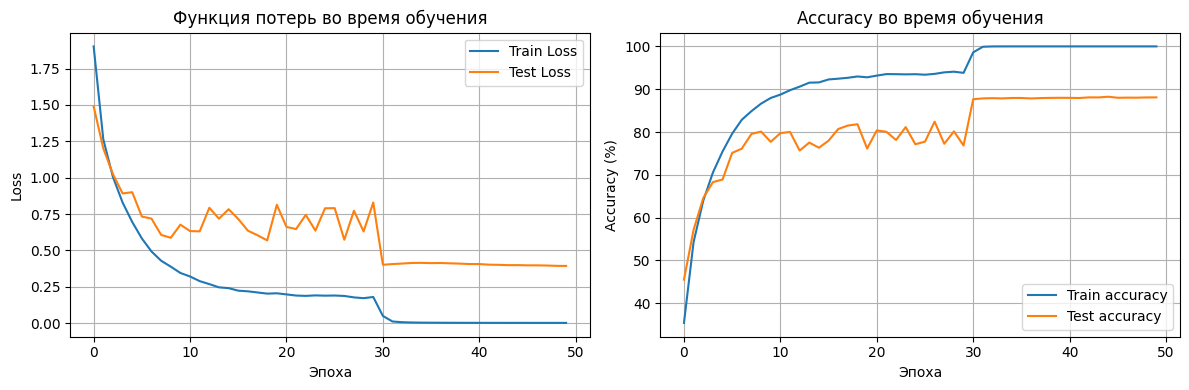

In [63]:
# График функции потерь
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Функция потерь во время обучения')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# График точности
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train accuracy')
plt.plot(test_accuracies, label='Test accuracy')
plt.title('Accuracy во время обучения')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [64]:
# Оценка модели на тестовом наборе
model.load_state_dict(torch.load('best_resnet18_cifar10.pth'))
final_test_loss, final_test_accuracy = calculate_test_loss_and_accuracy(model, testloader, criterion)
print(f'Финальная ошибка классификации на тестовом наборе: {final_test_loss:.2f}')
print(f'Финальная точность на тестовом наборе: {final_test_accuracy:.2f}%')

Финальная ошибка классификации на тестовом наборе: 0.40
Финальная точность на тестовом наборе: 88.24%


/tmp/ipython-input-367884579.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = images[i] * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)


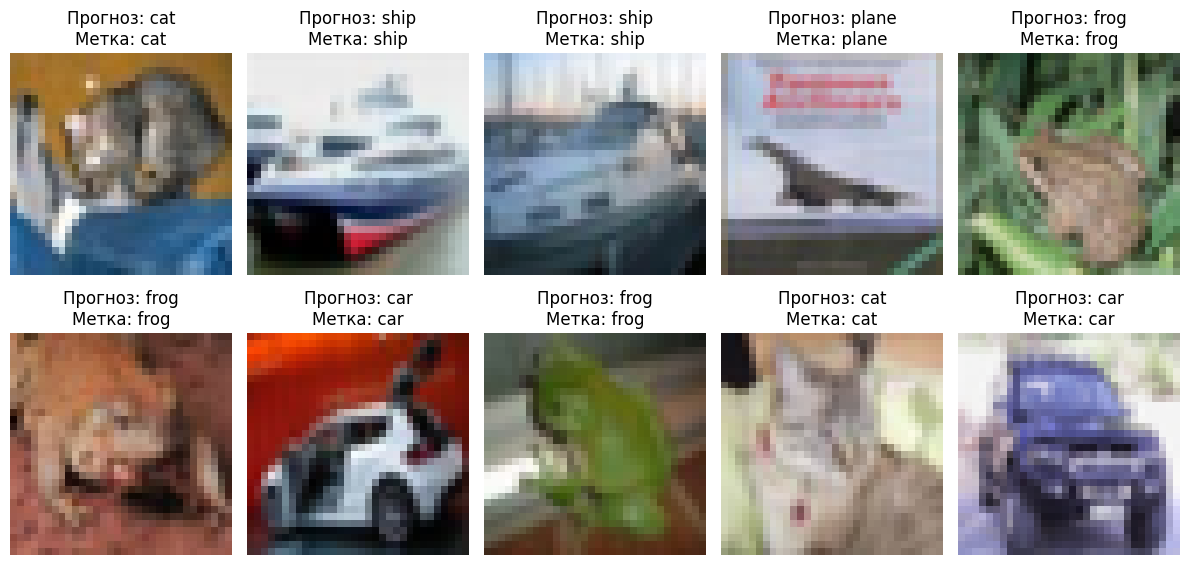

In [65]:
# Визуализация предсказаний на нескольких тестовых изображениях
model.eval()
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, predicted = torch.max(outputs, 1)


images = images.cpu()
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    ax = axes[i//5, i%5]
    img = images[i] * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
    img = torch.clamp(img, 0, 1)
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title(f'Прогноз: {classes[predicted[i]]}\nМетка: {classes[labels[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

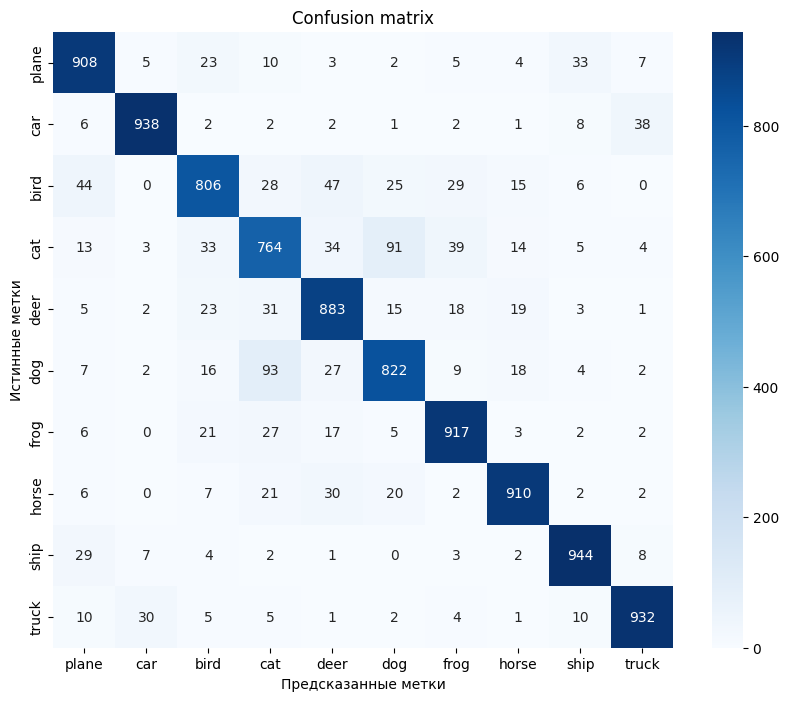

In [66]:
# Матрица ошибок
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion matrix')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.show()